# Hyperparameter Optimization

i.e. how to improve our model through **changing how our model is built**.

<img src="fig/frankestein.jpg" width="150"> <img src="fig/terminator.jpg" width="150"> <img src="fig/wolverine.png" width="150">

 **Hello There!**         

There are four fairly common strategies to optimize one model's hyperparameters.

<img src="fig/hyperparameter_meme_2.jpg" width="400">

*List in descending order of coolness*

Let's try applying some of these techniques to our titanic dataset

In [1]:
source('src/lib.R')

In [2]:
# import training and testing dataset

train = read_csv('data/titanic_train.csv', col_types = cols())
test = read_csv('data/titanic_test.csv', col_types = cols())

## Grid Search

This is the stupidest plossibly conveivable method.
1. Try lots of combinations
2. Select the best one

It is also the simplest to implement and it is not a coincidence that it is natively built in *Caret*. 

The only thing you should do is to declare the parameter $\texttt{tuneGrid}$ when invoking *Caret*'s $\texttt{train}$ function.

Note that:
- $\texttt{tuneGrid}$ is initialized as NULL
- $\texttt{tuneGrid}$ must be passed a named $\texttt{data.frame}$ (plz read: "a table with column names :)")

Finding which hyperparameters can be passed to our train function is farily easy:

In [3]:
info = getModelInfo()
info$kknn$parameters

parameter,class,label
kmax,numeric,Max. #Neighbors
distance,numeric,Distance
kernel,character,Kernel


As you see, *kknn* can be passed three parameters, two of which are of *numeric* type while the latter should be a *string*

> if you decide to pass a tuning grid, you **must** declare a data.frame which would include **all** the parameters available. In our case, a data.frame with three columns (and, ofc, at least one row)

While the concept of *kmax* argument may be of easy understanding, the same cannot be said of *distance* and *kernel*. As we saw in a previous lesson, to know more model-specific hyperparameters, you can refer to the reference manual of the given package, from which the model you are about to train is taken. 

In [4]:
info$kknn$library ## as easy as that

[1] "kknn"

And [here](https://cran.r-project.org/web/packages/kknn/kknn.pdf) you have it. It turns out that
- $\texttt{kmax}$ best number of k neighbours less or equal to k.
- $\texttt{distance}$ is the parameter of the [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) which, as **everybody** knows, takes value in $(0;+\infty)$
- $\texttt{kernel}$ is Kernel function to use. Possible choices are "rectangular" (which is standard unweighted knn), "triangular", "epanechnikov" (or beta(2,2)), "biweight" (or beta(3,3)), "triweight"
(or beta(4,4)), "cos", "inv", "gaussian", "rank" and "optimal".

In [19]:
## istantiate the tuning grid

(tune_grid = expand.grid(kmax = 5, 
                        kernel = c('rectangular',
                                   'epanechnikov',
                                   'gaussian'),
                        distance = c(0.1, 1, 2, 10)
                        )
)

kmax,kernel,distance
5,rectangular,0.1
5,epanechnikov,0.1
5,gaussian,0.1
5,rectangular,1.0
5,epanechnikov,1.0
5,gaussian,1.0
5,rectangular,2.0
5,epanechnikov,2.0
5,gaussian,2.0
5,rectangular,10.0


In [31]:
## train the model (you really don't want to run this)

set.seed(123) # to allow reproducibility of cross validation split

model_grid_search = train(x = train %>% select(-one_of('survived')),
                          y = train %>% select(one_of('survived')) %>% pull %>% factor,
                          method = 'kknn',
                          tuneGrid = tune_grid,
                          trControl = trainControl(search = "grid",
                                                   method = 'cv',
                                                   p = 0.9,
                                                   number = 10)
                    )

saveRDS(model_grid_search, 'data/model_grid_search.R')


# rather, we trained the model for you, how nice are we?!?

(model_grid_search = readRDS('data/model_grid_search.R'))

k-Nearest Neighbors 

918 samples
  8 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 826, 826, 827, 826, 826, 826, ... 
Resampling results across tuning parameters:

  kernel        distance  Accuracy   Kappa    
  rectangular    0.1      0.7647277  0.5050678
  rectangular    1.0      0.7756808  0.5276294
  rectangular    2.0      0.7822384  0.5409750
  rectangular   10.0      0.7669255  0.5090487
  epanechnikov   0.1      0.7690874  0.5151978
  epanechnikov   1.0      0.7746058  0.5270524
  epanechnikov   2.0      0.7593526  0.4937877
  epanechnikov  10.0      0.7516842  0.4792981
  gaussian       0.1      0.7658027  0.5063947
  gaussian       1.0      0.7690874  0.5122864
  gaussian       2.0      0.7854873  0.5493309
  gaussian      10.0      0.7724319  0.5197580

Tuning parameter 'kmax' was held constant at a value of 5
Accuracy was used to select the optimal model using the largest value.
The final values used fo

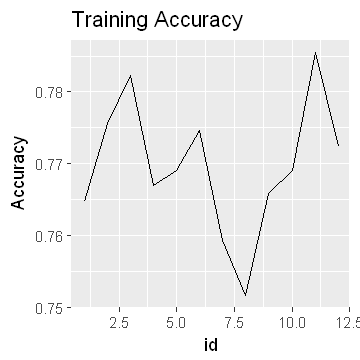

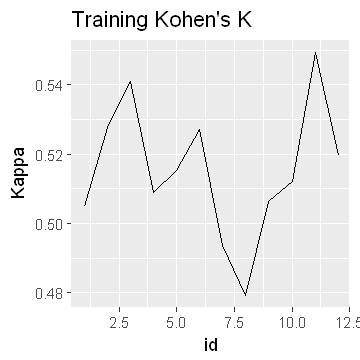

In [33]:
options(repr.plot.width=3, repr.plot.height=3)

model_grid_search$results %>%
  as_data_frame %>%
  rownames_to_column(var = 'id') %>% mutate(id = as.numeric(id)) %>% 
  ggplot() + geom_line(aes(x = id, y = Accuracy)) + ggtitle('Training Accuracy')

model_grid_search$results %>%
  as_data_frame %>%
  rownames_to_column(var = 'id') %>% mutate(id = as.numeric(id)) %>% 
  ggplot() + geom_line(aes(x = id, y = Kappa)) + ggtitle('Training Kohen\'s K')

Looks like there is a clear winner here!

In [14]:
model_grid_search$results %>% as_data_frame %>% top_n(1, Accuracy)
model_grid_search$results %>% as_data_frame %>% top_n(1, Kappa)

kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
5,gaussian,2,0.7854873,0.5493309,0.04690475,0.09699774


kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
5,gaussian,2,0.7854873,0.5493309,0.04690475,0.09699774


In [15]:
model_grid_search$bestTune # indeed

,kmax,distance,kernel
9,5,2,gaussian


### Computational Issues

As you see, (if you tried training the model yourself) the model takes a **looong** time to train

Indeed, grid search is often not viable when the hyperparameter space gets lerger, indeed, it gets exponentially complex.

## Manual Search

This may seem trivial, but it actually requires a good undertstanding of the underlying problem + it can help in reducing the space of grid search.

## Random Search

grid search looked promising but is there a better way to do it?

Randomly sampling in the hyperparameter space may yield good results with less computing time. Also, it allows us to explore even larger hyperparameter space!

In [30]:
## this is a very large tune grid. The previous had 50 rows, this one has 1000!


((tune_grid_large = expand.grid(kmax = 5, 
                        kernel = c('rectangular',
                                   'triangular',
                                   'epanechnikov',
                                   'biweight',
                                   'triweight',
                                   'cos',
                                   'inv',
                                   'gaussian',
                                   'rank',
                                   'optimal'),
                        distance = c(0.1, 0.5, 1, 2, 10)
                        )
)
) %>% nrow %>% paste('This tune grid has ', ., ' rows!')

[1] "This tune grid has  50  rows!"

kmax,kernel,distance
5,rectangular,0.1
5,triangular,0.1
5,epanechnikov,0.1
5,biweight,0.1
5,triweight,0.1
5,cos,0.1
5,inv,0.1
5,gaussian,0.1
5,rank,0.1
5,optimal,0.1


Let's tune!

In [35]:
## train the model (you really don't want to run this)

set.seed(123) # to allow reproducibility of cross validation split

model_random_search = train(x = train %>% select(-one_of('survived')),
                          y = train %>% select(one_of('survived')) %>% pull %>% factor,
                          method = 'kknn',
                          tuneGrid = tune_grid_large,
                          tuneLength = 12,
                          trControl = trainControl(search = 'random',
                                                   method = 'cv',
                                                    p = 0.9,
                                                    number = 10)
                    )

saveRDS(model_random_search, 'data/model_random_search.R')


# rather we trained the model for you, how nice are we?!?

(model_random_search = readRDS('data/model_random_search.R'))

k-Nearest Neighbors 

918 samples
  8 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 826, 826, 827, 826, 826, 826, ... 
Resampling results across tuning parameters:

  kernel        distance  Accuracy   Kappa    
  rectangular    0.1      0.7647277  0.5050678
  rectangular    0.5      0.7582656  0.4940242
  rectangular    1.0      0.7756808  0.5276294
  rectangular    2.0      0.7822384  0.5409750
  rectangular   10.0      0.7669255  0.5090487
  triangular     0.1      0.7549092  0.4866654
  triangular     0.5      0.7669613  0.5118017
  triangular     1.0      0.7702341  0.5179775
  triangular     2.0      0.7626254  0.5028035
  triangular    10.0      0.7473364  0.4721920
  epanechnikov   0.1      0.7690874  0.5151978
  epanechnikov   0.5      0.7734950  0.5253527
  epanechnikov   1.0      0.7746058  0.5270524
  epanechnikov   2.0      0.7593526  0.4937877
  epanechnikov  10.0      0.7516842  0.4792981
  biweight   

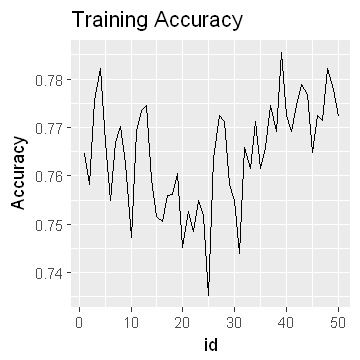

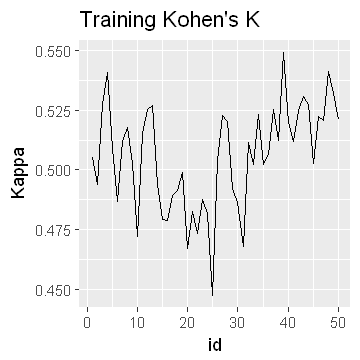

In [36]:
options(repr.plot.width=3, repr.plot.height=3)

model_random_search$results %>%
  as_data_frame %>%
  rownames_to_column(var = 'id') %>% mutate(id = as.numeric(id)) %>% 
  ggplot() + geom_line(aes(x = id, y = Accuracy)) + ggtitle('Training Accuracy')

model_random_search$results %>%
  as_data_frame %>%
  rownames_to_column(var = 'id') %>% mutate(id = as.numeric(id)) %>% 
  ggplot() + geom_line(aes(x = id, y = Kappa)) + ggtitle('Training Kohen\'s K')

In [46]:
model_random_search$results %>%
    filter(Accuracy > 0.7505602) %>%
    arrange(Accuracy %>% desc())

kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
18,inv,1.0,0.7683301,0.5017835,0.01995212,0.04314774
18,inv,0.5,0.7676365,0.5002822,0.02050050,0.04604183
19,inv,10.0,0.7627800,0.4902948,0.01821173,0.03794882
10,inv,10.0,0.7530325,0.4707292,0.02456427,0.05157329


Wow! with the same training time we found four solution better than with grid search!
- 1.6% accuracy improvement
- this would have taken 20 times the time, if done with random search
- also note that these may not be the *best* values, but they do they job fairly good, don't you think?

## Bayesian Optimization

[Google says](https://cloud.google.com/blog/big-data/2017/08/hyperparameter-tuning-in-cloud-machine-learning-engine-using-bayesian-optimization) it works the best.

This is a greedy approach (not a grid approach ;) ) in the sense that it is aimed at quickly maximize potentially locally optimal solution. But fast! 
> if you think about it, finding the optimal solution would certainly mean overfitting!

### Gaussian Processes

<img src="fig/escher.jpg" width="400">

*Graphical representation of how to use a machine learning model to improve another machine learning model.*


Interestingly enough, Bayesian Hypermarameter Optimization relies on another machine learning algowitm (Gaussian Process) to **infer the latent accuracy (or loss)** distibution in the hyperparameters space, thus allowinn a  more efficient search of hyperparameters which are looked after in the most **promising** regions. 

In [ ]:
### include example with rBayesianOptimization

library(rBayesianOptimization)

rBayesianOptimization::BayesianOptimization()

willBeOptimized = function(KMAX, KERNEL, DIST){
  
  partition = train %>% nrow %>% seq_len %>% createDataPartition(p = 0.5, list= FALSE)
  
  train_train = train %>% slice(partition)
  
  val = train %>% slice(-partition)
  
  kernel = c('rectangular',
             'triangular',
             'epanechnikov',
             'biweight',
             'triweight',
             'cos',
             'inv',
             'gaussian',
             'rank',
             'optimal'                                  
  )
  
  kernel = kernel[KERNEL]
  
  model = train(x = train_train %>% select(-one_of('survived')),
                y = train_train %>% select(one_of('survived')) %>% pull %>% factor,
                method = 'kknn',
                trControl = trainControl(search = 'grid', method = 'none'),
                tuneGrid = data.frame(kmax = KMAX,
                                      kernel = kernel,
                                      distance = DIST)
  )
  
  
  test_response = model %>%
    predict(newdata = val %>% select(-one_of('survived'))) %>% factor
  
  acc = confusionMatrix(val %>% select(one_of('survived')) %>% pull %>% factor,
                        test_response)

  test_response_probabilities = model %>%
    predict(newdata = val %>% select(-one_of('survived')),  type = 'prob') %>% pull('1')
  
  roc = roc(test_response_probabilities, val$survived %>% factor) %>% auc
  
  return(list('Score' = roc,#acc$overall[1],
              'Pred' = test_response))  
}

In [ ]:
xx = BayesianOptimization(willBeOptimized,
                          bounds = list(KMAX = c(1L, 20L),
                                        KERNEL = c(1L, 10L),
                                        DIST = c(0.1, 10)),
                          init_points = 20,
                          n_iter = 40,
                          acq = 'ei')

In [ ]:
xx$History %>% as_data_frame %>% ggplot(aes(x = KMAX, y = DIST)) +
  stat_density_2d() + geom_point(aes(size = Round, colour = -Value)) #+
  geom_path(aes(colour = as.numeric(-Round)))
# this plot could be made interactive by showing how the bayesian optimization explore the feature space!!!


### Known issues o rBayesianOptimization

While this is not a limitation of Bayesian Search in general, the R package rBayesianOptimization cannot yet handle qualitative hyperparameter (i guess so!!!)

## Honest Toughts / Takeouts

- A better understanding of the problem and of the relationship and a good definition of the model/models to start with does the best of the work
    
- The larger the problem, the more incentive you have in going towards "smart" approaches, cf. Random Search and Bayesian Optimization. It is unlikely you will ever face a problem of a truly large size.

> The two above are especially true for complex problem, where the deadly combination of hyperparameter space size and training time leads to the **curse of dimensionality**


- If the problem is simple and/or well known, you'd be better off with a quick and dirty manual search.

- There is a lot of emphasis on gaining that little extra bit of performance (Kaggle competitions...), while a real-world task is pretty much aimed at finding a non useless solution. Basis-point improvement of AR are effectively worth nuts. 